In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from models.discriminator import get_discriminator
from models.generator import get_generator
from models.encoder import get_encoder
from tqdm import tqdm
from joblib import load
import os
os.environ['CUDA_VISIBLE_DEVICES']='-1'
from pathlib import Path
from os import path
from utils.wasserstein_dist import wasserstein_dist
from utils.loaddata import generate_boundary_data, generate_interior_data, get_data
import seaborn as sns

The 2-D nonlinear Allen-Cahn equation:
\begin{equation}
    \begin{split}
        & c \cdot ((u_x)^2 + (u_y)^2) + u(u^2-1) = f, \hspace{1em} \text{(P.D.E.),} \hspace{1em} (x,y) \in [-1,1] \times [-1,1]\\
        & u(x,y) = 0, \hspace{1em}  \text{(B.C.).}
    \end{split}
\end{equation}
Here, the exact solution is set to be $u(x,y) = \sin(\pi  x) \cdot \sin (\pi  y)$ and the corresponding $f(x,y)$.

Similarly, instead of deterministic boundary data, we consider random (noised) boundary conditions, i.e., 
\begin{equation}
    \begin{split}
         u(x,y=-1) \sim \mathcal{N}(0,\sigma_1), \hspace{0.5em}  \text{(B.C.1)} & \hspace{1em}
         u(x,y=1) \sim \mathcal{N}(0,\sigma_2), \hspace{0.5em}  \text{(B.C.2)}\\
         u(x=-1,y) \sim \mathcal{N}(0,\sigma_3), \hspace{0.5em} \text{(B.C.3)} &  \hspace{1em}  
         u(x=1,y) \sim \mathcal{N}(0,\sigma_4), \hspace{0.5em} \text{(B.C.4)}
    \end{split}
\end{equation}
and we let noise levels $\sigma_1 = \cdots = \sigma_4=0.05$. 

In [2]:
tf.random.set_seed(666666)
np.random.seed(666666)

# Define some hyper-parameters 
noise_level = 0.05
par_pinns = 0.5 # hyperparameter to balance wgan and pinns regularization term
N_r = 500 # number of training data for residual (k in my paper)
N_u = 500 # number of training data for uncertain boundary/initial conditions (m=n in my paper)
z_shape = 2 # we adopt 2-dimensional standard normal noise as input for uncertainty quantification
g_depth = 2 # depth of generators (D_g)
g_width = 50 # width of generators (W_g)
d_depth = 2 # depth of discriminators (D_f)
d_width = 50 # width of discriminators
lrg = 1e-4 # learning rate for generators
lrd = 1e-4 # learning rate for discriminators
beta_1 = 0.9
beta_2 = 0.99 # those two beta_s are for Adam optimizor.
bjorck_beta = 0.5 
bjorck_iter = 5
bjorck_order = 2 # hyper-parameters for bjorck orthonomalization iteration
group_size = 2 # groupsize of groupsort neural networks
num_itr = 80000 # maximun number of itertions

In [3]:
class WGAN_PINNs(object):

    def __init__(self,
                 noise_level=0.05,
                 N_r=200,
                 N_u=20,
                 X_mean=0,
                 X_std=1,
                 Y_mean=1,
                 Y_std=1,
                 par_pinns=1,
                 z_shape=50,
                 out_dim=1,
                 num_itr=50,
                 g_depth=5,
                 g_width=64,
                 d_depth=5,
                 d_width=64,
                 lrg=1e-4,
                 lrd=1e-4,
                 beta_1=0.9,
                 beta_2=0.999,
                 bjorck_beta=0.5,
                 bjorck_iter=5,
                 bjorck_order=2,
                 group_size=2):

        self.noise_level = noise_level
        self.N_r = N_r
        self.N_u = N_u
        self.X_mean = X_mean
        self.X_std = X_std
        self.Y_mean = Y_mean
        self.Y_std = Y_std
        self.z_shape = z_shape
        self.out_dim = out_dim
        self.num_itr = num_itr
        self.JacobianX = 1 / self.X_std
        self.JacobianY = 1 / self.Y_std
        self.par_pinns = par_pinns
        self.x_shape = 2
        # For each iteration, we update the discriminator 2 times and then update the generator 5 times
        self.k_d = 2
        self.k_g = 5

        self.d_depth = d_depth
        self.d_width = d_width
        self.g_depth = g_depth
        self.g_width = g_width

        # network initialization
        self.G = get_generator(input_shape=(self.z_shape + self.x_shape,), output_shape=self.out_dim, depth=g_depth,
                               width=g_width)
        self.D = get_discriminator(input_shape=(self.out_dim + self.x_shape,), depth=d_depth, width=d_width,
                                   bjorck_beta=bjorck_beta, bjorck_iter=bjorck_iter, bjorck_order=bjorck_order,
                                   group_size=group_size)
        # self.E = get_encoder(input_shape=(self.z_shape + self.x_shape,), depth=2, width=50)
        self.G_optimizer = Adam(learning_rate=lrg, beta_1=beta_1, beta_2=beta_2)
        self.D_optimizer = Adam(learning_rate=lrd, beta_1=beta_1, beta_2=beta_2)
        
        self.Loss = 0.0
    
    # r.h.s. of the pde
    def f(self, XY_normalized):
        X = XY_normalized[:, 0][:,None] * self.X_std + self.X_mean
        Y = XY_normalized[:, 1][:,None] * self.Y_std + self.Y_mean
        return (np.pi ** 2) * 0.01 * (
                 (tf.cos(np.pi * X) ** 2) * (tf.sin(np.pi * Y) ** 2) + (tf.sin(np.pi * X) ** 2) * (tf.cos(
              np.pi * Y) ** 2)) + (tf.sin(np.pi * X) ** 3) * (tf.sin(np.pi * Y) ** 3) - tf.sin(np.pi * X) * tf.sin(np.pi * Y)


    def generator_loss(self, fake_output, residual):
        return tf.math.reduce_mean(fake_output) + self.par_pinns * residual

    def discriminator_loss(self, real_output, fake_output):
        return -tf.math.reduce_mean(fake_output) + tf.math.reduce_mean(real_output)
    
    # residual
    def get_r(self, XY_r, noises):
        X_r = XY_r[:, 0][:, None]
        Y_r = XY_r[:, 1][:, None]
        with tf.GradientTape(persistent=True, watch_accessed_variables=False) as pde_tape1:
            pde_tape1.watch([X_r, Y_r])
            u = self.G(tf.concat([noises, X_r, Y_r], axis=1), training=True)
        u_x = pde_tape1.gradient(u, X_r)
        u_y = pde_tape1.gradient(u, Y_r)
        f = self.f(XY_r)
        r = 0.01 * ((self.JacobianX ** 2) * (u_x ** 2) + (self.JacobianY ** 2) * (u_y ** 2)) + u ** 3 - u - f
        r2 = r ** 2
        return tf.math.reduce_mean(r2)

    @tf.function()
    def train_step_discriminator(self, X_u, XY_u, noises_u):
        with tf.GradientTape() as disc_tape:
            generated_Y = self.G(tf.concat([noises_u, X_u], axis=1), training=False)

            real_output = self.D(XY_u, training=True)
            fake_output = self.D(tf.concat([X_u, generated_Y], axis=1), training=True)

            disc_loss = self.discriminator_loss(real_output, fake_output)

        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.D.trainable_variables)

        self.D_optimizer.apply_gradients(zip(gradients_of_discriminator, self.D.trainable_variables))

    @tf.function()
    def train_step_generator(self, X_u, X_r, noises_u, noises_r):
        with tf.GradientTape(persistent=True) as gen_tape:
            generated_Y = self.G(tf.concat([noises_u, X_u], axis=1), training=True)

            fake_output = self.D(tf.concat([X_u, generated_Y], axis=1), training=False)

            residual = self.get_r(X_r, noises_r)

            gen_loss = self.generator_loss(fake_output, residual)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.G.trainable_variables)

        self.G_optimizer.apply_gradients(zip(gradients_of_generator, self.G.trainable_variables))
    
    # generator one sample at X
    def generate_sample(self, X):
        num = X.shape[0]
        noise = tf.random.normal([num, self.z_shape])
        return self.G(tf.concat([noise, X], axis=1), training=False)

    # calculate the relative error of the generator
    def get_relative_error(self, X, Y, l2, num_test):
        # noises = tf.random.normal([num_test, self.z_shape])
        samples = np.zeros((num_test, 2000), dtype=np.float32)
        for i in range(0, 2000):
            samples[:, i:i + 1] = self.generate_sample(X)

        Y_predicted = np.mean(samples, axis=1, dtype=np.float32)[:, None]

        return np.sqrt(tf.reduce_mean(tf.square(Y_predicted - Y)) / l2)

    
    # mini-batch
    def get_minibatch(self, XY_r, XYU_u, XY_u, batchsize_r=100, batchsize_u = 50):
        idx_r = np.random.choice(self.N_r, batchsize_r, replace=False)
        idx_u = np.random.choice(self.N_u * 4, batchsize_u, replace=False)

        return XY_r[idx_r,:], XYU_u[idx_u,:], XY_u[idx_u,:]



    def train(self, XYU_u, XY_r, XY_test):
        print('--------------Begin Training-----------------')
        num = 1000
        XYU = generate_boundary_data(noise_level=self.noise_level, N_u=num, X_mean=self.X_mean, X_std=self.X_std,
                                     Y_mean=self.Y_mean, Y_std=self.Y_std)
        XY = XYU[:, 0:2]
        
        num_test = XY_test.shape[0]
        XY_u = XYU_u[:, 0:2]
        XY_test = tf.convert_to_tensor(XY_test)
        
        time1 = time.time()
        batchsize_r = 250
        batchsize_u = 1000
        for itr in range(self.num_itr):
            XY_r_batch, XYU_u_batch, XY_u_batch = self.get_minibatch(XY_r, XYU_u, XY_u, batchsize_r, batchsize_u)
            noises_u = tf.random.normal([batchsize_u, self.z_shape])
            noises_r = tf.random.normal([batchsize_r, self.z_shape])
            for i in range(self.k_d):
                self.train_step_discriminator(XY_u_batch, XYU_u_batch, noises_u)

            for j in range(self.k_g):
                self.train_step_generator(XY_u_batch, XY_r_batch, noises_u, noises_r)

            if (itr + 1) % 5000 == 0:
                noises_u = tf.random.normal([4 * num, self.z_shape])
                noises_test = tf.random.normal([num_test, self.z_shape])
                r2_loss = self.get_r(XY_test, noises_test)
                u_predict = self.G(tf.concat([noises_u, XY], axis=1), training=False)
                w_dis = tf.math.reduce_mean(
                    self.D(tf.concat([XY, u_predict], axis=1), training=False)) - tf.math.reduce_mean(
                    self.D(XYU, training=False))
                print(
                    "itr {}, r2_loss is {:4f}, W loss is {:5f}; Time: {:4f}.\n".format(
                        itr + 1, r2_loss, w_dis,
                        time.time() - time1))
                time1 = time.time()

In [4]:
XYU_u, XY_r, XY_test, X_mean, X_std, Y_mean, Y_std = get_data(noise_level=noise_level, N_r = N_r, N_u = N_u)

wgan_pinns = WGAN_PINNs(noise_level=noise_level, N_r=N_r, N_u=N_u, X_mean=X_mean, X_std=X_std, Y_mean=Y_mean, Y_std=Y_std, par_pinns=par_pinns, z_shape=z_shape, num_itr=num_itr, 
                        g_depth=g_depth, g_width=g_width, d_depth=d_depth, d_width=d_width, lrg=lrg, lrd=lrd, beta_1=beta_1, beta_2=beta_2, bjorck_beta=bjorck_beta, 
                        bjorck_iter=bjorck_iter, bjorck_order=bjorck_order, group_size=group_size)

wgan_pinns.train(XYU_u, XY_r, XY_test)

--------------Begin Training-----------------
itr 5000, r2_loss is 0.000690, W loss is 0.000211; Time: 102.734035.

itr 10000, r2_loss is 0.000974, W loss is -0.000180; Time: 103.445642.

itr 15000, r2_loss is 0.000274, W loss is 0.000076; Time: 97.947287.

itr 20000, r2_loss is 0.000798, W loss is -0.000222; Time: 98.356498.

itr 25000, r2_loss is 0.000482, W loss is -0.000044; Time: 98.655788.

itr 30000, r2_loss is 0.000399, W loss is -0.000079; Time: 98.825413.

itr 35000, r2_loss is 0.000392, W loss is -0.000034; Time: 99.169133.

itr 40000, r2_loss is 0.000395, W loss is -0.000037; Time: 99.784103.

itr 45000, r2_loss is 0.000320, W loss is -0.000011; Time: 100.359172.

itr 50000, r2_loss is 0.000336, W loss is 0.000065; Time: 101.062504.

itr 55000, r2_loss is 0.000579, W loss is -0.000131; Time: 102.004874.

itr 60000, r2_loss is 0.000482, W loss is -0.000051; Time: 102.650293.

itr 65000, r2_loss is 0.000324, W loss is 0.000013; Time: 104.204241.

itr 70000, r2_loss is 0.00027

In [5]:
def get_solution(XT_normalized, X_mean, X_std, Y_mean, Y_std):
    X = XT_normalized[:, 0][:, None] * X_std + X_mean
    Y = XT_normalized[:, 1][:, None] * Y_std + Y_mean
    return np.sin(np.pi * X) * np.sin(np.pi * Y)

XY_test = generate_interior_data(N_test=100, X_mean=X_mean, X_std=X_std, Y_mean=Y_mean, Y_std=Y_std)
U_test = get_solution(XY_test, X_mean=X_mean, X_std=X_std, Y_mean=Y_mean, Y_std=Y_std)
l2 = np.mean(np.square(U_test))
samples = np.zeros((100*100, 2000), dtype=np.float32)
for i in range(0, 2000):
    samples[:, i:i + 1] = wgan_pinns.generate_sample(XY_test)
U_predicted = np.mean(samples, axis=1)[:,None]
rel_error = np.sqrt(np.mean(np.square(U_predicted - U_test)) / l2)
print('The relative error of ontained generator is {:.3e}.'.format(rel_error))

The relative error of ontained generator is 2.585e-02.


The above are the tutorial part. The following part shows the relative error during the training. The relative error decreases fast at the first 10 thousand iterations, and then becomes stable within the range from 2e-2 to 5e-2.

In [1]:
! python run.py train --hparam='basic_params1'

--------------Begin Training-----------------
itr 2000, rel_error is 4.176357e-01 r2_loss is 0.015466, W loss is 0.000349; Time: 51.237152.

itr 4000, rel_error is 6.998801e-02 r2_loss is 0.001037, W loss is 0.000180; Time: 48.453073.

itr 6000, rel_error is 6.548883e-02 r2_loss is 0.000748, W loss is 0.000121; Time: 49.062542.

itr 8000, rel_error is 5.701816e-02 r2_loss is 0.000687, W loss is 0.000031; Time: 54.453268.

itr 10000, rel_error is 6.471071e-02 r2_loss is 0.000574, W loss is -0.000026; Time: 50.359267.

itr 12000, rel_error is 5.411363e-02 r2_loss is 0.000574, W loss is -0.000096; Time: 51.190729.

itr 14000, rel_error is 3.602464e-02 r2_loss is 0.000278, W loss is 0.000081; Time: 50.856339.

itr 16000, rel_error is 4.056652e-02 r2_loss is 0.000408, W loss is 0.000058; Time: 50.562194.

itr 18000, rel_error is 5.473125e-02 r2_loss is 0.000577, W loss is -0.000070; Time: 51.390636.

itr 20000, rel_error is 4.130387e-02 r2_loss is 0.000348, W loss is -0.000007; Time: 51.295

2021-07-31 16:27:17.359397: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library cudart64_101.dll
2021-07-31 16:27:19.533375: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library nvcuda.dll
2021-07-31 16:27:19.562759: E tensorflow/stream_executor/cuda/cuda_driver.cc:314] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-07-31 16:27:19.565789: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: GAOYihang
2021-07-31 16:27:19.565844: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: GAOYihang
2021-07-31 16:27:19.566240: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow w

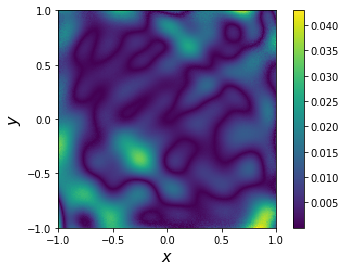

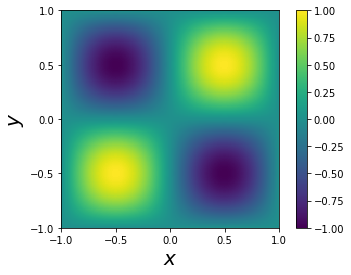

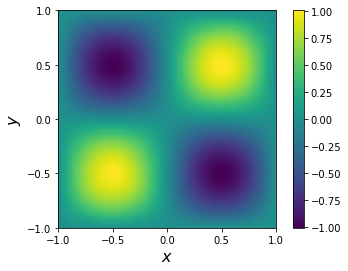

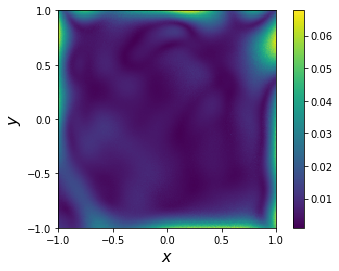

In [4]:
data_0 = np.load("data_0.05.npy")
mean_data = np.mean(data_0, axis=1)[:,None]
mean_data = np.flip(np.reshape(mean_data, newshape=(201,201)),axis=0)
std_data = np.std(data_0, axis=1)
std_data = np.flip(np.reshape(std_data, newshape=(201,201)),axis=0)

def u(X, Y):
    return np.sin(np.pi * X) * np.sin(np.pi * Y)


X = np.linspace(-1,1,201)
Y = np.linspace(-1,1,201)
X = np.broadcast_to(X[None, :, None], (201, 201, 1))
Y = np.broadcast_to(Y[:, None, None], (201, 201, 1))
XY = np.concatenate((X, Y), axis=-1)
XY = np.reshape(XY, newshape=(-1,2))

U = u(XY[:,0][:,None], XY[:,1][:,None])
U = np.flip(np.reshape(U, newshape=(201,201)),axis=0)

error = np.abs(U - mean_data)
img = plt.imshow(error, interpolation='nearest', extent=[-1, 1, -1, 1])
# plt.clim(0, 0.1)
plt.colorbar(img)
plt.xlabel("$x$", fontsize=16)
plt.ylabel("$y$", fontsize=16)
plt.xticks(np.arange(-1, 1.5, step=0.5)) 
plt.yticks(np.arange(-1, 1.5, step=0.5)) 
plt.show()

img2 = plt.imshow(U, interpolation='nearest', extent=[-1, 1, -1, 1])
plt.colorbar(img2)
plt.xlabel("$x$", fontsize=20)
plt.ylabel("$y$", fontsize=20)
plt.xticks(np.arange(-1, 1.5, step=0.5)) 
plt.yticks(np.arange(-1, 1.5, step=0.5)) 
plt.show()

img3 = plt.imshow(mean_data, interpolation='nearest', extent=[-1, 1, -1, 1])
plt.colorbar(img3)
plt.xlabel("$x$", fontsize=16)
plt.ylabel("$y$", fontsize=16)
plt.xticks(np.arange(-1, 1.5, step=0.5)) 
plt.yticks(np.arange(-1, 1.5, step=0.5)) 
plt.show()

img4 = plt.imshow(std_data, interpolation='nearest', extent=[-1, 1, -1, 1])
plt.colorbar(img4)
plt.xlabel("$x$", fontsize=16)
plt.ylabel("$y$", fontsize=16)
plt.xticks(np.arange(-1, 1.5, step=0.5)) 
plt.yticks(np.arange(-1, 1.5, step=0.5)) 
plt.show()

D:\Softwares\miniconda3\envs\gyh_tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Softwares\miniconda3\envs\gyh_tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


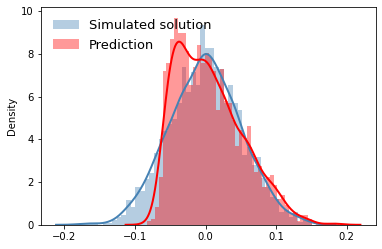

D:\Softwares\miniconda3\envs\gyh_tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Softwares\miniconda3\envs\gyh_tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


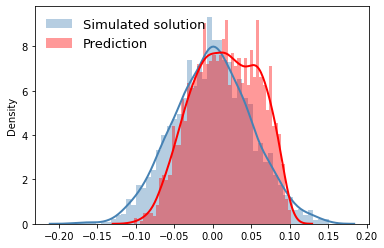

D:\Softwares\miniconda3\envs\gyh_tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Softwares\miniconda3\envs\gyh_tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


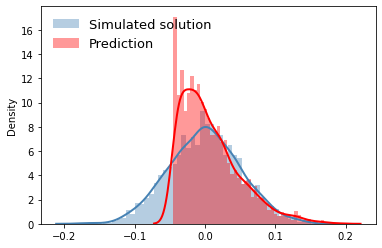

D:\Softwares\miniconda3\envs\gyh_tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Softwares\miniconda3\envs\gyh_tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


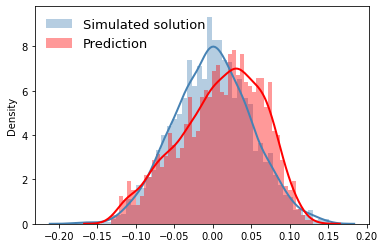

In [5]:
Y1 = data_0[201*0+100,:]
Y2 = np.random.normal(loc=0,scale=0.05,size=2000)
plt.figure()
sns.distplot(Y2, hist=True, kde=True, bins=50, color='steelblue', hist_kws={'edgecolor':'None'}, kde_kws={'linewidth':2}, label='Simulated solution')
sns.distplot(Y1, hist=True, kde=True, bins=50, color='red', hist_kws={'edgecolor':'None'}, kde_kws={'linewidth':2}, label="Prediction")
plt.legend(loc='upper left', frameon=False, prop={'size': 13})
plt.show()

Y1 = data_0[201*100,:]
plt.figure()
sns.distplot(Y2, hist=True, kde=True, bins=50, color='steelblue', hist_kws={'edgecolor':'None'}, kde_kws={'linewidth':2}, label='Simulated solution')
sns.distplot(Y1, hist=True, kde=True, bins=50, color='red', hist_kws={'edgecolor':'None'}, kde_kws={'linewidth':2}, label="Prediction")
plt.legend(loc='upper left', frameon=False, prop={'size': 13})
plt.show()

Y1 = data_0[201*100+200,:]
plt.figure()
sns.distplot(Y2, hist=True, kde=True, bins=50, color='steelblue', hist_kws={'edgecolor':'None'}, kde_kws={'linewidth':2}, label='Simulated solution')
sns.distplot(Y1, hist=True, kde=True, bins=50, color='red', hist_kws={'edgecolor':'None'}, kde_kws={'linewidth':2}, label="Prediction")
plt.legend(loc='upper left', frameon=False, prop={'size': 13})
plt.show()

Y1 = data_0[201*200+100,:]
plt.figure()
sns.distplot(Y2, hist=True, kde=True, bins=50, color='steelblue', hist_kws={'edgecolor':'None'}, kde_kws={'linewidth':2}, label='Simulated solution')
sns.distplot(Y1, hist=True, kde=True, bins=50, color='red', hist_kws={'edgecolor':'None'}, kde_kws={'linewidth':2}, label="Prediction")
plt.legend(loc='upper left', frameon=False, prop={'size': 13})
plt.show()